# Reusable Embeddings

**Learning Objectives**
1. Learn how to use a pre-trained TF Hub text modules to generate sentence vectors.
1. Learn how to incorporate a pre-trained TF-Hub module into a Keras model.


## Introduction


In this notebook, we will implement text models to recognize the probable source (Github, Tech-Crunch, or The New-York Times) of the titles we have in the title dataset.

First, we will load and pre-process the texts and labels so that they are suitable to be fed to sequential Keras models with first layer being TF-hub pre-trained modules. Thanks to this first layer, we won't need to tokenize and integerize the text before passing it to our models. The pre-trained layer will take care of that for us, and consume directly raw text. However, we will still have to one-hot-encode each of the 3 classes into a 3 dimensional basis vector.

Then we will build, train and compare simple DNN models starting with different pre-trained TF-Hub layers.

In [1]:
import os

from google.cloud import bigquery
import pandas as pd

In [2]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


Replace the variable values in the cell below:

In [ ]:
PROJECT = "qwiklabs-gcp-00-082cafb2093a"  # Replace with your PROJECT
BUCKET = PROJECT 
REGION = "us-central1"

os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION

## Create a Dataset from BigQuery 

Hacker news headlines are available as a BigQuery public dataset. The [dataset](https://bigquery.cloud.google.com/table/bigquery-public-data:hacker_news.stories?tab=details) contains all headlines from the sites inception in October 2006 until October 2015. 

Here is a sample of the dataset:

In [4]:
%%bigquery --project $PROJECT

SELECT
    url, title, score
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    LENGTH(title) > 10
    AND score > 10
    AND LENGTH(url) > 0
LIMIT 10

Query is running:   0%|          |

/opt/conda/envs/tensorflow/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2438: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/envs/tensorflow/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2452: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/envs/tensorflow/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2466: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


Downloading:   0%|          |

,url,title,score
0,https://blog.amigocloud.com/sub-meter-data-col...,Entire Golf Course at Centimeter Accuracy – Fr...,11
1,http://perspectives.mvdirona.com/2009/10/14/Re...,Does it make sense to replace all disks with S...,11
2,https://www.aclu.org/blog/national-security-te...,ACLU-Obtained Documents Reveal Breadth of Secr...,11
3,https://git.kernel.org/cgit/linux/kernel/git/t...,Hurr durr I'ma sheep,11
4,http://bit-player.org/2015/mrs-nguyens-prestid...,Mrs. Nguyen’s prestidigitation,11
5,http://parametricity.com/posts/2015-02-19-anim...,Animating Abstractly,11
6,http://www.reuters.com/article/2015/02/16/us-f...,Small farmers hold the key to seed diversity: ...,11
7,http://digitalcommons.unl.edu/cgi/viewcontent....,Are Political Orientations Genetically Transmi...,11
8,http://www.psmag.com/health-and-behavior/how-t...,How the American opiate epidemic was started b...,11
9,http://www.bloomberg.com/news/videos/2015-02-2...,Check Out Washio on Bloomberg West Today,11


Let's do some regular expression parsing in BigQuery to get the source of the newspaper article from the URL. For example, if the url is http://mobile.nytimes.com/...., I want to be left with <i>nytimes</i>

In [5]:
%%bigquery --project $PROJECT

SELECT
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.'))[safe_offset (1)] AS source,
    COUNT(title) AS num_articles
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.com$')
    AND LENGTH(title) > 10
GROUP BY
    source
ORDER BY num_articles DESC
  LIMIT 100

Query is running:   0%|          |

/opt/conda/envs/tensorflow/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2438: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/envs/tensorflow/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2452: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/envs/tensorflow/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2466: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


Downloading:   0%|          |

,source,num_articles
0,github,183581
1,medium,134373
2,youtube,129422
3,nytimes,84901
4,blogspot,62136
...,...,...
95,itworld,3163
96,nextplatform,3155
97,atlasobscura,3078
98,anandtech,3015


Now that we have good parsing of the URL to get the source, let's put together a dataset of source and titles. This will be our labeled dataset for machine learning.

In [6]:
regex = '.*://(.[^/]+)/'


sub_query = """
SELECT
    title,
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '{0}'), '.'))[safe_offset (1)] AS source
    
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '{0}'), '.com$')
    AND LENGTH(title) > 10
""".format(regex)


query = """
SELECT 
    LOWER(REGEXP_REPLACE(title, '[^a-zA-Z0-9 $.-]', ' ')) AS title,
    source
FROM
  ({sub_query})
WHERE (source = 'github' OR source = 'nytimes' OR source = 'techcrunch')
""".format(sub_query=sub_query)

print(query)


SELECT 
    LOWER(REGEXP_REPLACE(title, '[^a-zA-Z0-9 $.-]', ' ')) AS title,
    source
FROM
  (
SELECT
    title,
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.'))[safe_offset (1)] AS source
    
FROM
    `bigquery-public-data.hacker_news.full`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.com$')
    AND LENGTH(title) > 10
)
WHERE (source = 'github' OR source = 'nytimes' OR source = 'techcrunch')



For ML training, we usually need to split our dataset into training and evaluation datasets (and perhaps an independent test dataset if we are going to do model or feature selection based on the evaluation dataset). AutoML however figures out on its own how to create these splits, so we won't need to do that here. 



In [7]:
bq = bigquery.Client(project=PROJECT)
title_dataset = bq.query(query).to_dataframe()
title_dataset.head()

/opt/conda/envs/tensorflow/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2438: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/envs/tensorflow/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2452: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/envs/tensorflow/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2466: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


,title,source
0,the new face of committing in github for mac,github
1,a git notifier for mac os x written in go,github
2,show hn hue-wheel for html5 browsers,github
3,send ripples from salesforce,github
4,grind polishes go programs,github


AutoML for text classification requires that
* the dataset be in csv form with 
* the first column being the texts to classify or a GCS path to the text 
* the last colum to be the text labels

The dataset we pulled from BiqQuery satisfies these requirements.

In [8]:
print("The full dataset contains {n} titles".format(n=len(title_dataset)))

The full dataset contains 328310 titles


Let's make sure we have roughly the same number of labels for each of our three labels:

In [9]:
title_dataset.source.value_counts()

source
github        183581
nytimes        84901
techcrunch     59828
Name: count, dtype: int64

Finally we will save our data, which is currently in-memory, to disk.

We will create a csv file containing the full dataset and another containing only 1000 articles for development.

**Note:** It may take a long time to train AutoML on the full dataset, so we recommend to use the sample dataset for the purpose of learning the tool. 


In [10]:
DATADIR = './data/'

if not os.path.exists(DATADIR):
    os.makedirs(DATADIR)

In [11]:
FULL_DATASET_NAME = 'titles_full.csv'
FULL_DATASET_PATH = os.path.join(DATADIR, FULL_DATASET_NAME)

# Let's shuffle the data before writing it to disk.
title_dataset = title_dataset.sample(n=len(title_dataset))

title_dataset.to_csv(
    FULL_DATASET_PATH, header=False, index=False, encoding='utf-8')

Now let's sample 1000 articles from the full dataset and make sure we have enough examples for each label in our sample dataset (see [here](https://cloud.google.com/natural-language/automl/docs/beginners-guide) for further details on how to prepare data for AutoML).

In [12]:
sample_title_dataset = title_dataset.sample(n=1000)
sample_title_dataset.source.value_counts()

source
github        550
nytimes       269
techcrunch    181
Name: count, dtype: int64

Let's write the sample datatset to disk.

In [13]:
SAMPLE_DATASET_NAME = 'titles_sample.csv'
SAMPLE_DATASET_PATH = os.path.join(DATADIR, SAMPLE_DATASET_NAME)

sample_title_dataset.to_csv(
    SAMPLE_DATASET_PATH, header=False, index=False, encoding='utf-8')

In [14]:
import datetime
import os
import shutil

import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow_hub import KerasLayer
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical


print(tf.__version__)

2025-07-16 09:42:15.362055: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-16 09:42:21.637920: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/lib/x86_64-linux-gnu/:/opt/conda/lib
2025-07-16 09:42:21.638164: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local

2.11.0


In [15]:
%matplotlib inline

Let's start by specifying where the information about the trained models will be saved as well as where our dataset is located:

In [16]:
MODEL_DIR = "./text_models"
DATA_DIR = "./data"

## Loading the dataset

As in the previous labs, our dataset consists of titles of articles along with the label indicating from which source these articles have been taken from (GitHub, Tech-Crunch, or the New-York Times):

In [17]:
ls ./data/

titles_full.csv  titles_sample.csv


In [18]:
DATASET_NAME = "titles_full.csv"
TITLE_SAMPLE_PATH = os.path.join(DATA_DIR, DATASET_NAME)
COLUMNS = ['title', 'source']

titles_df = pd.read_csv(TITLE_SAMPLE_PATH, header=None, names=COLUMNS)
titles_df.head()

,title,source
0,purple flares got you down camhoodie case for...,techcrunch
1,stacey 2.2.2 - html5boilerplate edition,github
2,an argument against cloud-based applications,techcrunch
3,show hn list and selectively download files f...,github
4,the type of practice matters more than hours,nytimes


Let's look again at the number of examples per label to make sure we have a well-balanced dataset:

In [19]:
titles_df.source.value_counts()

source
github        183581
nytimes        84901
techcrunch     59828
Name: count, dtype: int64

## Preparing the labels

In this lab, we will use pre-trained [TF-Hub embeddings modules for english](https://tfhub.dev/s?q=tf2%20embeddings%20text%20english) for the first layer of our models. One immediate
advantage of doing so is that the TF-Hub embedding module will take care for us of processing the raw text. 
This also means that our model will be able to consume text directly instead of sequences of integers representing the words.

However, as before, we still need to preprocess the labels into one-hot-encoded vectors:

In [20]:
CLASSES = {
    'github': 0,
    'nytimes': 1,
    'techcrunch': 2
}
N_CLASSES = len(CLASSES)

In [21]:
def encode_labels(sources):
    classes = [CLASSES[source] for source in sources]
    one_hots = to_categorical(classes, num_classes=N_CLASSES)
    return one_hots

In [22]:
encode_labels(titles_df.source[:4])

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

## Preparing the train/test splits

Let's split our data into train and test splits:

In [23]:
N_TRAIN = int(len(titles_df) * 0.95)

titles_train, sources_train = (
    titles_df.title[:N_TRAIN], titles_df.source[:N_TRAIN])

titles_valid, sources_valid = (
    titles_df.title[N_TRAIN:], titles_df.source[N_TRAIN:])

To be on the safe side, we verify that the train and test splits
have roughly the same number of examples per class.

Since it is the case, accuracy will be a good metric to use to measure
the performance of our models.

In [24]:
sources_train.value_counts()

source
github        174432
nytimes        80605
techcrunch     56857
Name: count, dtype: int64

In [25]:
sources_valid.value_counts()

source
github        9149
nytimes       4296
techcrunch    2971
Name: count, dtype: int64

Now let's create the features and labels we will feed our models with:

In [26]:
X_train, Y_train = titles_train.values, encode_labels(sources_train)
X_valid, Y_valid = titles_valid.values, encode_labels(sources_valid)

In [27]:
X_train[:3]

array(['purple flares got you down  camhoodie case for iphone 5 can help',
       'stacey 2.2.2 - html5boilerplate edition',
       'an argument against cloud-based applications'], dtype=object)

In [28]:
Y_train[:3]

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

## NNLM Model

We will first try a word embedding pre-trained using a [Neural Probabilistic Language Model](http://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf). TF-Hub has a 50-dimensional one called 
[nnlm-en-dim50-with-normalization](https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1), which also
normalizes the vectors produced. 

Once loaded from its url, the TF-hub module can be used as a normal Keras layer in a sequential or functional model. Since we have enough data to fine-tune the parameters of the pre-trained embedding itself, we will set `trainable=True` in the `KerasLayer` that loads the pre-trained embedding:

In [ ]:
# TODO 
NNLM = "https://tfhub.dev/google/nnlm-en-dim50/2"

nnlm_module = KerasLayer(
    NNLM, output_shape=[50], input_shape=[], dtype=tf.string, trainable=True)

2025-07-16 09:54:19.348113: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/lib/x86_64-linux-gnu/:/opt/conda/lib
2025-07-16 09:54:19.351379: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2025-07-16 09:54:19.353872: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cloudlearningservices): /proc/driver/nvidia/version does not exist
2025-07-16 09:54:19.358256: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them i

Note that this TF-Hub embedding produces a single 50-dimensional vector when passed a sentence:

In [ ]:
# TODO
nnlm_module(tf.constant(["The dog is happy to see people in the street."]))

<tf.Tensor: shape=(1, 50), dtype=float32, numpy=
array([[ 0.19331802,  0.05893906,  0.15330684,  0.2505918 ,  0.19369544,
         0.03578748,  0.07387847, -0.10962156, -0.11377034,  0.07172022,
         0.12458669, -0.02289705, -0.18177685, -0.07084437, -0.00225849,
        -0.36875236,  0.05772953, -0.14222091,  0.08765972, -0.14068899,
        -0.07005888, -0.20634466,  0.07220475,  0.04258814,  0.0955702 ,
         0.19424029, -0.42492998, -0.00706906, -0.02095   , -0.05055764,
        -0.18988201, -0.02841404,  0.13222624, -0.01459922, -0.31255388,
        -0.09577855,  0.05469003, -0.13858607,  0.01141668, -0.12352604,
        -0.07250367, -0.11605677, -0.06976165,  0.14313601, -0.15183711,
        -0.06836402,  0.03054246, -0.13259597, -0.14599673,  0.05094011]],
      dtype=float32)>

## Swivel Model

Then we will try a word embedding obtained using [Swivel](https://arxiv.org/abs/1602.02215), an algorithm that essentially factorizes word co-occurrence matrices to create the words embeddings. 
TF-Hub hosts the pretrained [gnews-swivel-20dim-with-oov](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1) 20-dimensional Swivel module.

In [ ]:

# TODO
SWIVEL = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1"
swivel_module = KerasLayer(
    SWIVEL, output_shape=[20], input_shape=[], dtype=tf.string, trainable=True)

Similarly as the previous pre-trained embedding, it outputs a single vector when passed a sentence:

In [ ]:
# TODO
swivel_module(tf.constant(["The dog is happy to see people in the street."]))

<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[ 0.9967701 , -0.3100155 ,  0.5889897 , -0.16765082, -0.6171738 ,
        -1.1586996 , -0.8619045 ,  0.7281645 ,  0.32575002,  0.4754492 ,
        -0.9272241 ,  0.41090095, -0.75389475, -0.31525993, -1.8918804 ,
         0.6423996 ,  0.6801622 , -0.1335669 , -1.0017993 , -0.11908641]],
      dtype=float32)>

## Building the models

Let's write a function that 

* takes as input an instance of a `KerasLayer` (i.e. the `swivel_module` or the `nnlm_module` we constructed above) as well as the name of the model (say `swivel` or `nnlm`)
* returns a compiled Keras sequential model starting with this pre-trained TF-hub layer, adding one or more dense relu layers to it, and ending with a softmax layer giving the probability of each of the classes:

In [ ]:
def build_model(hub_module, name):
    model = Sequential([
        hub_module, # TODO
        Dense(16, activation='relu'),
        Dense(N_CLASSES, activation='softmax')
    ], name=name)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Let's also wrap the training code into a `train_and_evaluate` function that 
* takes as input the training and validation data, as well as the compiled model itself, and the `batch_size`
* trains the compiled model for 100 epochs at most, and does early-stopping when the validation loss is no longer decreasing
* returns an `history` object, which will help us to plot the learning curves

In [40]:
def train_and_evaluate(train_data, val_data, model, batch_size=5000):
    X_train, Y_train = train_data

    tf.random.set_seed(33)

    model_dir = os.path.join(MODEL_DIR, model.name)
    if tf.io.gfile.exists(model_dir):
        tf.io.gfile.rmtree(model_dir)

    history = model.fit(
        X_train, Y_train,
        epochs=10,
        batch_size=batch_size,
        validation_data=val_data,
        callbacks=TensorBoard(model_dir),
    )
    return history

## Training NNLM

In [41]:
data = (X_train, Y_train)
val_data = (X_valid, Y_valid)

In [42]:
nnlm_model = build_model(nnlm_module, 'nnlm')
nnlm_history = train_and_evaluate(data, val_data, nnlm_model)

Epoch 1/10


2025-07-16 10:03:31.331673: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 192762400 exceeds 10% of free system memory.
2025-07-16 10:03:31.564477: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 192762400 exceeds 10% of free system memory.
2025-07-16 10:03:32.473034: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 192762400 exceeds 10% of free system memory.
2025-07-16 10:03:32.485175: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 192762400 exceeds 10% of free system memory.


63/63 [==============================] - 43s 661ms/step - loss: 0.8547 - accuracy: 0.6257 - val_loss: 0.6109 - val_accuracy: 0.7477
Epoch 2/10
63/63 [==============================] - 38s 599ms/step - loss: 0.4683 - accuracy: 0.8199 - val_loss: 0.3699 - val_accuracy: 0.8649
Epoch 3/10
63/63 [==============================] - 37s 594ms/step - loss: 0.3084 - accuracy: 0.8865 - val_loss: 0.2958 - val_accuracy: 0.8857
Epoch 4/10
63/63 [==============================] - 78s 1s/step - loss: 0.2526 - accuracy: 0.9048 - val_loss: 0.2732 - val_accuracy: 0.8940
Epoch 5/10
63/63 [==============================] - 75s 1s/step - loss: 0.2255 - accuracy: 0.9152 - val_loss: 0.2651 - val_accuracy: 0.8967
Epoch 6/10
63/63 [==============================] - 81s 1s/step - loss: 0.2083 - accuracy: 0.9220 - val_loss: 0.2626 - val_accuracy: 0.8977
Epoch 7/10
63/63 [==============================] - 81s 1s/step - loss: 0.1958 - accuracy: 0.9273 - val_loss: 0.2633 - val_accuracy: 0.8977
Epoch 8/10
63/63 [====

<Axes: >

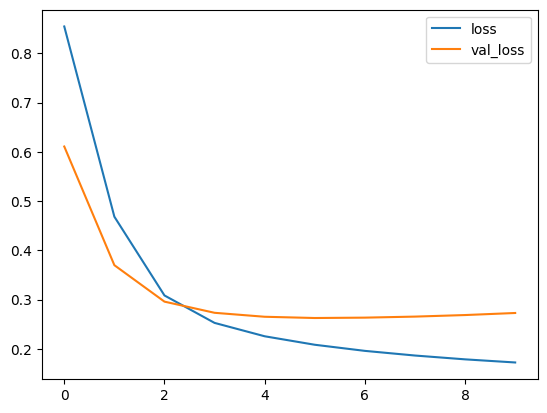

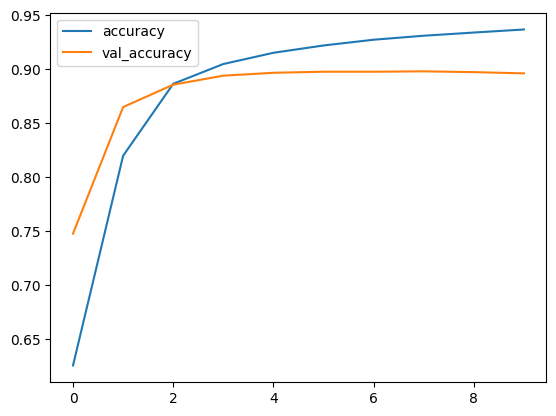

In [43]:
history = nnlm_history
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

## Training Swivel

In [44]:
swivel_model = build_model(swivel_module, name='swivel')

In [45]:
swivel_history = train_and_evaluate(data, val_data, swivel_model)

Epoch 1/10
63/63 [==============================] - 2s 23ms/step - loss: 1.2382 - accuracy: 0.3374 - val_loss: 0.9483 - val_accuracy: 0.5588
Epoch 2/10
63/63 [==============================] - 1s 21ms/step - loss: 0.8401 - accuracy: 0.6325 - val_loss: 0.7546 - val_accuracy: 0.6802
Epoch 3/10
63/63 [==============================] - 1s 21ms/step - loss: 0.6815 - accuracy: 0.7146 - val_loss: 0.6200 - val_accuracy: 0.7458
Epoch 4/10
63/63 [==============================] - 2s 25ms/step - loss: 0.5628 - accuracy: 0.7696 - val_loss: 0.5232 - val_accuracy: 0.7862
Epoch 5/10
63/63 [==============================] - 2s 35ms/step - loss: 0.4836 - accuracy: 0.8041 - val_loss: 0.4642 - val_accuracy: 0.8081
Epoch 6/10
63/63 [==============================] - 2s 31ms/step - loss: 0.4351 - accuracy: 0.8243 - val_loss: 0.4285 - val_accuracy: 0.8258
Epoch 7/10
63/63 [==============================] - 1s 20ms/step - loss: 0.4035 - accuracy: 0.8380 - val_loss: 0.4047 - val_accuracy: 0.8375
Epoch 8/10
63

<Axes: >

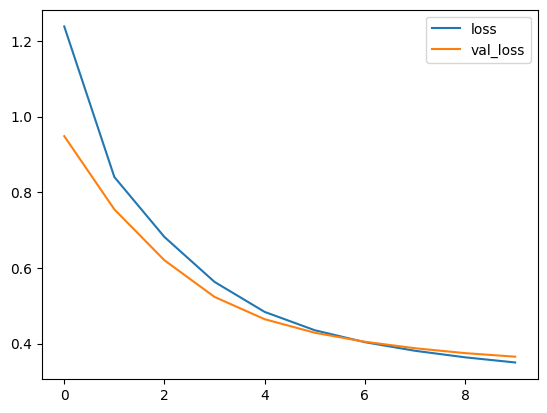

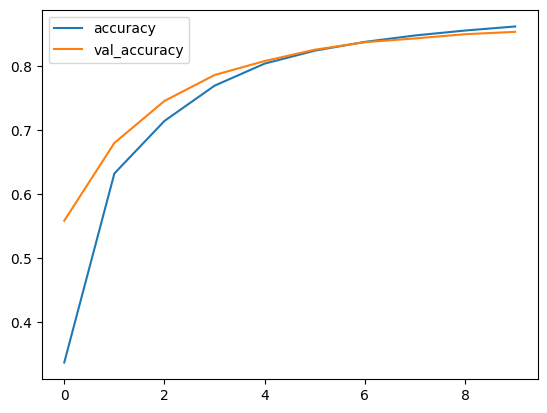

In [46]:
history = swivel_history
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

Swivel trains faster but achieves a lower validation accuracy, and requires more epochs to train on.

## Bonus

Try to beat the best model by modifying the model architecture, changing the TF-Hub embedding, and tweaking the training parameters.

Copyright 2023 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License